<a href="https://colab.research.google.com/github/pablo-arantes/tRMSF/blob/main/tRMSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install Cython

#load dependencies
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors
from IPython.display import set_matplotlib_formats

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
import MDAnalysis.transformations as trans
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align
import pandas as pd

#@title **Please, provide the necessary input files below**: 
#@markdown **Important:** Selection is the same used in VMD. Amber, Gromacs and CHARMM topologies are accepted. Trajectories in XTC, TRR, DCD and PDB format are also accepted.

Google_Drive_Path = '/content/drive/MyDrive' #@param {type:"string"}
workDir = Google_Drive_Path
top = 'SYS.top' #@param {type:"string"}
traj = 'traj.dcd' #@param {type:"string"}
skip = '10' #@param {type:"string"}
Selection = "name CA" #@param {type:"string"}

directory = "trajectories"
parent_dir = "/content/"
if os.path.exists('/content/trajectories/'):
  pass
else:
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

files = os.listdir('/content/trajectories/')
for file in files:
    os.remove('/content/trajectories/' + file)

TOP = os.path.join(workDir, str(top))
TRAJ = os.path.join(workDir, str(traj))

u=mda.Universe(TOP,TRAJ)

average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
ref = average.universe

# aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

aligner = align.AlignTraj(u, ref, 
                          select='protein and name CA', 
                          filename='aligned_traj.dcd',
                          in_memory=False).run()

u = mda.Universe(TOP, 'aligned_traj.dcd')

protein = u.select_atoms("protein")
protein.write("protein.pdb")

rmsf_frames = []
rmsf_residues = []
rmsf_time = []

for i in range(0, len(u.trajectory), int(skip)):
  with mda.Writer("/content/trajectories/protein_"+ str(i) + ".dcd", protein.n_atoms) as W:
    for ts in u.trajectory[i:(i+int(skip)):]:
        W.write(protein, )
  u1=mda.Universe("protein.pdb","/content/trajectories/protein_"+ str(i) + ".dcd")
  domain = u1.select_atoms(str(Selection))
  R = RMSF(domain).run()
  rmsf = R.results.rmsf
  residues = domain.residues.resids
  time = np.repeat(i, len(residues))
  rmsf_frames.append(rmsf)
  rmsf_residues.append(residues)
  rmsf_time.append(time)
  print("Done Frame " + str(i))

#prepare the data to plot
df = pd.DataFrame(rmsf_frames)
new_frames = df.to_numpy()
df = pd.DataFrame(rmsf_time)
new_time = df.to_numpy()
df = pd.DataFrame(rmsf_residues)
new_residues = df.to_numpy()
z_new = new_frames.transpose()
Z1 = np.flip(z_new,axis=0) 

Done Frame 0
Done Frame 20
Done Frame 40
Done Frame 60
Done Frame 80
Done Frame 100
Done Frame 120
Done Frame 140
Done Frame 160
Done Frame 180
Done Frame 200
Done Frame 220
Done Frame 240
Done Frame 260
Done Frame 280
Done Frame 300
Done Frame 320
Done Frame 340
Done Frame 360
Done Frame 380
Done Frame 400
Done Frame 420
Done Frame 440
Done Frame 460
Done Frame 480
Done Frame 500
Done Frame 520
Done Frame 540
Done Frame 560
Done Frame 580
Done Frame 600
Done Frame 620
Done Frame 640
Done Frame 660
Done Frame 680
Done Frame 700
Done Frame 720
Done Frame 740
Done Frame 760
Done Frame 780
Done Frame 800
Done Frame 820
Done Frame 840
Done Frame 860
Done Frame 880


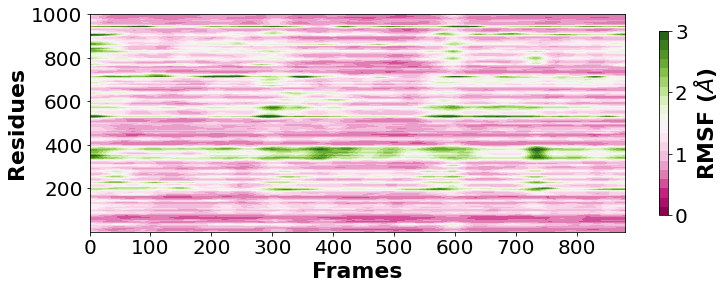

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import BSpline
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

#@title **Plot the tRMSF**
#@markdown **Provide output file names below:** 

#@markdown Selections are the range of your residues.

Output_name = 'tRMSF' #@param {type:"string"}
selection1 = '1' #@param {type:"string"}
selection2 = '1000' #@param {type:"string"}
RMSF_value_limit = '3' #@param {type:"string"}

x = new_time
y = new_residues
z = Z1
max_X = np.amax(x)
max_y = np.amax(y)
min_x = np.amin(x)
min_y = np.amin(y)

plt.figure(figsize=(12, 4))
plt.imshow(z, extent=[min_x, max_X, min_y, max_y], cmap=plt.cm.get_cmap('PiYG',20), interpolation='bicubic', alpha=1, aspect='auto', vmin = 0, vmax = float(RMSF_value_limit))

plt.xlabel('Frames', fontname = 'Arial', fontsize = 22, fontweight = 'bold')
plt.ylabel('Residues', fontname = 'Arial', fontsize = 22, fontweight = 'bold')
cbar1 = plt.colorbar(orientation="vertical", shrink=0.85, pad=0.05)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('RMSF ($\AA$)', fontname = 'Arial', fontsize = 22, fontweight = 'bold')
plt.yticks(fontname = 'Verdana', size=20)
plt.xticks(fontname = 'Verdana', size=20)
# plt.xlim(0, 6000)
plt.ylim(int(selection1), int(selection2))

#Save the raw data and plot
np.savetxt(os.path.join(workDir, Output_name + "_tRMSF.txt"), z)
np.savetxt(os.path.join(workDir, Output_name + "_time.txt"), x)
np.savetxt(os.path.join(workDir, Output_name + "_residues.txt"), y)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

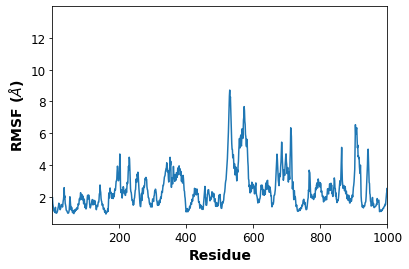

In [ ]:
#@title **Plot the RMSF**
#@markdown **Provide output file names below:** 

#@markdown Selections are the range of your residues.

Output_name = 'RMSF' #@param {type:"string"}
selection1 = '1' #@param {type:"string"}
selection2 = '1000' #@param {type:"string"}


# u=mda.Universe(TOP,TRAJ1)

# average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
# ref = average.universe

# aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

sele = u.select_atoms("name CA")

R = RMSF(sele).run()
rmsf = R.results.rmsf
residues = domain.residues.resids

plt.plot(residues, rmsf)
plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(residues[0], residues[-1])
plt.xlim(int(selection1), int(selection2))

plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Save the RMSF values as custom B factors**
#@markdown **Provide output file names below:** 
Output_name = 'PDB_RMSF' #@param {type:"string"}

pdb_rmsf = os.path.join(workDir, str(Output_name) + ".pdb")

sele = u.select_atoms("name CA")

R = RMSF(sele).run()
rmsf_data = pd.DataFrame(R.rmsf,index=sele.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue 
rmsf_3d=[]
protein_write = u.select_atoms("protein")
protein_write.write("protein_bfactor.pdb")
u1=mda.Universe("protein_bfactor.pdb","protein_bfactor.pdb")
u1.add_TopologyAttr('tempfactors') #Initialization of B factors (tempfactors) by MDA in the Universe atoms
for atom in u1.atoms:
    rmsf_3d.append(rmsf_data.loc[atom.resid,'RMSF']) #A new list of RMSF must be created by ATOM. Our table has this values per aC. We can create a longer list easily
with mda.Writer(pdb_rmsf, u1) as PDB: #This is the functionality from MDA which allos us to save PDB files.
    for ts in u1.trajectory: #I'll save just the first frame in PDB as snapshot  
        u1.atoms.tempfactors = rmsf_3d #This adds the custom B factors to the PDB snapshot 
        PDB.write(u1.atoms) 

pdb_check = os.path.exists(pdb_rmsf)
if pdb_check == True:
  print("Successfully generated PDB file! :-)")
else:
  print("ERROR: Check your inputs! ")

Successfully generated PDB file! :-)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

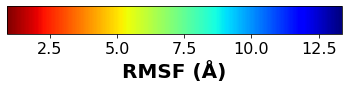

In [ ]:
#@title **Display 3D structure with RMSF values** {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

color = "RMSF" #@param ["chain", "RMSF", "rainbow"]


def show_pdb(color="RMSF"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_rmsf,'r').read(),'pdb')

  if color == "RMSF":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':min(rmsf_data['RMSF']),'max':max(rmsf_data['RMSF'])}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  view.zoomTo()
  return view


show_pdb(color).show() 

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet_r
norm = mpl.colors.Normalize(vmin=min(rmsf_data['RMSF']), vmax=max(rmsf_data['RMSF']))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('RMSF (Å)',fontsize=20,fontweight='bold')
cb1.ax.tick_params(labelsize=16) 
fig.show()